# MC886 - Projeto 1
Aluno: Mateus Feitosa Olivi  RA: 222059

# Parte 1:
    
<p style="text-align: justify;">
&emsp;Na primeira parte deste projeto o objetivo é implementar o algoritmos K-means e um outro algoritmo de aprendizado não supervisionado, no meu caso escolhi o Hierarchical Clustering. Após serem implementados o objetivo será analisar o comportamento dos algoritmos para diferentes valores de K, além de descobrir o melhor valor, também irei analisar o efeito da normalização dos dados de entrada, o efeito do inicialização dos centroides e tentar analisar qual dos algoritmos é o mais indicado para esse conjunto de dados

### 1. K-Means:
&emsp;O K-Means é um algoritmo de aprendizado não supervisionado, que faz a clusterização dos dados de entrada de acordo com suas características.<br>
&emsp;O algoritmo é bem simples, para fazer a clusterização basta que se execute os passos abaixo:
1. Definir um valor de K, ou seja, um número de clusters.
2. Inicializar os centroide para cada cluster.
3. Definir os clusters de cada ponto, o cluster que cada ponto pertence é referente ao centróide mais próximo, em termos de distancia euclidiana.
4. Reposicionar o centróide. A nova posição do centroide deve ser a média da posição de todos os pontos do cluster.
5. Repetir 3 e 4 até que os centróides não varie.
</p>

### 1.1 Implementação
<p style="text-align: justify;">&emsp;Inicialmente preciso fazer a leitura dos dados bem como sua normalização, para isso usarei a biblioteca pandas. A normalização utilizada será a Min-Max.<br>
&emsp;A minha função contará com um parametro "norm", caso esse seja true então a normalização será aplicada, optei por esse parametro porque mais a frente irei analisar o impacto da normalização.<br>
&emsp; Essa função também faz o split do dataset no dataset de traino e de teste, para pegar dados ao logo de todo dataset original eu fiz a seguinte divisão:</p>
<p style="text-align: center;"> | 18% treino | 2% teste | 18% treino | 2% teste | 18% treino | 2% teste | 18% treino | 2% teste | 18% treino | 2% teste |</p>
<p style="text-align: justify;">&emsp;Totalizando em 90% do dataset como treinamento e 10% como teste. O parametro dataset da função que irá definir se o dataset de treino ou de teste que será retornado, para isso basta passar como parametro as strings 'training' ou 'test'.</p>

In [2]:
import pandas as pd
from math import floor, ceil

def Dados(caminho, dataset = 'training', norm = True):
    X = pd.read_csv(caminho, sep = '\s+', header = None)
    if(norm):
        X = (X-X.min())/(X.max()-X.min()) # Min-Max
        
    training, test = [], []
    Total = len(X)
    
    for i in range(5):
        training.append(X.head(floor(Total*0.18)))
        X = X.iloc[floor(Total*0.18):]
        test.append(X.head(ceil(Total*0.02)))
        X = X.iloc[ceil(Total*0.02):]
    
    training = pd.concat(training)
    test = pd.concat(test)
    
    if(dataset == 'training'):
        return training.values
    elif(dataset == 'test'):
        return test.values

&emsp;Agora irei implementar a inicialização dos clusters e dos centroides.<br>
&emsp;O conjunto de clusters estara representado por um dicionario, cada chave desse dicionario referenciará um cluster diferente e cada cluster tem um conjunto de arrays que representam os pontos.<br>
&emsp;Os centroides serão inicializados utilizando o metódo Forgy, ou seja, para k clusters irão ser escolhidos k pontos aleatórios, pertecentes aos dados, para serem os centroides iniciais.

In [3]:
import numpy as np
import random as rd

def inicializaCluster(k):
    clusters = {}
    for i in range(k):
        clusters[i] = []
    return clusters

def inicializaCentroides(X,k):
    aux = X.tolist()
    centroides = rd.sample(aux, k)
    centroides = np.array(centroides)
    return centroides

&emsp;Já tendo preparado a inicialização dos clusters e dos centroides, agora preciso implementar as funções para definir os clusters e calcular a posição dos centroides.<br>
&emsp;Para se definir os clusters é medido a distancia entre os pontos e os centroides, então os pontos são definidos ao clusters cuja o centroide é o mais próximo.<br>
&emsp;Já os centroides são calculados sabendo que a nova posição do centroide deve ser a média da posição de todos os pontos do cluster.

In [4]:
def defineClusters(X, centroids, k):
    clusters = inicializaCluster(k) 
    for data in X:
        distancias = []
        for i in range(k):
            distancia = np.linalg.norm(data - centroids[i])
            distancias.append(distancia)
        clusters[distancias.index(min(distancias))].append(data)
    return clusters

def calculaCentroides(centroides, clusters, k):
    novo = cp.deepcopy(centroides)
    for i in range(k):
        novo[i] = np.average(clusters[i], axis=0)
    return novo

&emsp; Agora basta aplicar o algoritmo apresentado no inicio da explicacao e se obtém o seguinte código:

In [5]:
import copy as cp

def kmeans(X, k):
    centroides_anterior = inicializaCentroides(X,k)
    erro = 1
    while erro != 0:
        clusters = defineClusters(X, centroides_anterior, k)
        centroides_novo = calculaCentroides(centroides_anterior, clusters, k)
        erro = np.linalg.norm(centroides_novo - centroides_anterior)
        centroides_anterior = cp.deepcopy(centroides_novo)
    return clusters, centroides_novo 

&emsp; Pronto, o k-means foi finalizado, mas antes de aplica-lo para treinamento, vou implementar um método para achar o melhor valor para k.<br>
&emsp; O método a ser implementado será o método "elbow", o método do cotovelo, esse método consiste em plotar um gráfico com K Clusters vs Distorção, sendo a distorção a soma do quadrado das distancias entre os pontos do cluster e o centroide. <br>
&emsp;Após plotado o gráfico, deve se identificar uma mudança de comportamento no gráfico (cotovelo), que indica nosso melhor valor de K.<br>

In [6]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

def elbow(X):
    Grafico = []
    for k in range(1,10):
        Sum = 0
        clusters, centroides = kmeans(X, k)
        for i in range(len(clusters)):
            for j in range(len(clusters[i])):
                distancia = np.linalg.norm(clusters[i][j] - centroides[i])
                Sum += distancia**2
        Grafico.append([k,Sum])
    Grafico = np.array(Grafico)
    
    plt.plot(Grafico[:,0],Grafico[:,1], 'bx-')
    plt.xticks(Grafico[:,0])
    plt.xlabel('Valor de K')
    plt.ylabel('Distorção')
    plt.title('Método Elbow')
    plt.show()

### 1.2 Execução

&emsp;Inicialmente eu irei fazer a leitura dos dados, pegando os dados de treinamento (90% dos dados, explicado no primeiro tópico) e em seguida aplicar o método elbow, através da função elbow

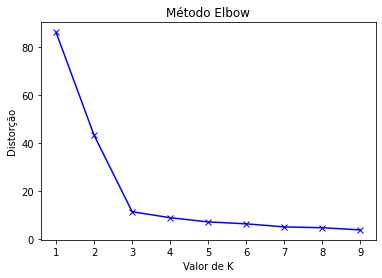

In [7]:
X = Dados('cluster.dat', dataset = 'training', norm = True)
elbow(X)

&emsp; Visivelmente, pelo método elbow, a melhor maneira para se clusterizar os dados são utilizando k = 3 clusters, com isso em mente, irei executar a função kmeans para k = 3:

In [8]:
X = Dados('cluster.dat', dataset = 'training', norm = True)
clusters, centroides = kmeans(X,k = 3)

&emsp; O código executou sem erros, agora vou fazer um código bem simples para mostrar o resultado da clusterizacao e ver se realmente o algoritmo produziu algo que faz sentido

In [9]:
def kmeansplot(clusters, centroides):
    cores = ['r','b','g','c','m','y']
    for i in range(len(clusters)):
        cluster = np.array(clusters[i])
        plt.scatter(cluster[:,0] , cluster[:,1], s=75, color=cores[i],  edgecolor='k',label='cluster '+str(i+1))

    plt.scatter(centroides[:, 0], centroides[:, 1], s=300, marker='*',c='yellow', edgecolor='k',label='centroides')
    plt.legend(scatterpoints=1)
    plt.show()

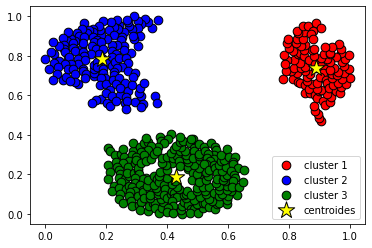

In [10]:
kmeansplot(clusters, centroides)

&emsp; Aparentemente o algoritmo elbow nos deu um valor ótimo de k, pois visualmente é possivel notar que a clusterização foi ótima e os clusters estão muito bem definidos.

### 1.3 Analise
&emsp;Neste tópico farei a análise do efeito da normalização e da inicialização do centróide.

#### 1.3.1 Normalização
&emsp; Inicialmente irei fazer a analise do efeito da normalização sobre a clusterização do k-means, para isso eu irei atribuir os dados de entrada, sem aplicar a normalização, à variavél X2.<br>
&emsp; Após isso irei executar a função elbow e plotar o gráfico para o kmeans, então irei analisar as diferenças entre a clusterização com e sem a normalização.

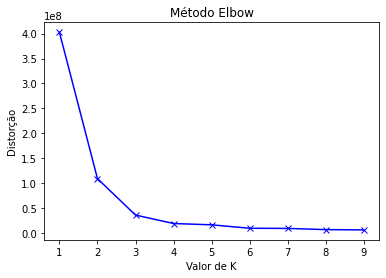

In [11]:
X2 = Dados('cluster.dat', dataset = 'training', norm = False)
elbow(X2)

&emsp; O método elbow, para esse caso, parece ser inconclusivo, porém como sabemos que para esses dados k = 3, vou aplicar o kmeans para esse k:

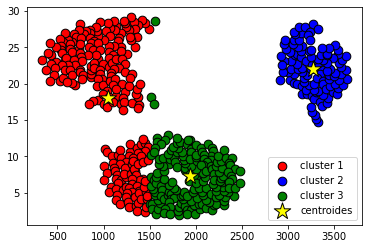

In [12]:
clusters2, centroides2 = kmeans(X2,k = 3)
kmeansplot(clusters2, centroides2)

&emsp; É possível notar que a clusterização ficou errada, mas isso já era de se esperar, como estamos trabalhando com distâncias euclidianas a escala das features importam muito, isso por que a diferença nas escalas das features implica em uma diferença na importancia das features para o kmeans. <br>
&emsp; Esse efeito fica evidente no gráfico acima, a escala do eixo y é 100 vezes menor que a do eixo x, então é natural que os pontos fossem clusterizados em setores verticais, visto que os pontos do gráfico estão 100 vezes mais próximos em y do que em x.<br>
&emsp; Para demonstrar o que estou dizendo, vou plotar novamento o gráfico, mas agora irei colocar a escala do eixo y próxima a escala do eixo x, mas sem alterar a escala dos dados:

In [13]:
def kmeansplot_2(clusters, centroides):
    cores = ['r','b','g','c','m','y']
    plt. ylim(1, 1500)
    for i in range(len(clusters)):
        cluster = np.array(clusters[i])
        plt.scatter(cluster[:,0] , cluster[:,1], s=75, color=cores[i] ,label='cluster '+str(i+1))

    plt.scatter(centroides[:, 0], centroides[:, 1], s=300, marker='*',c='yellow',label='centroides')
    plt.legend(scatterpoints=1)
    plt.show()

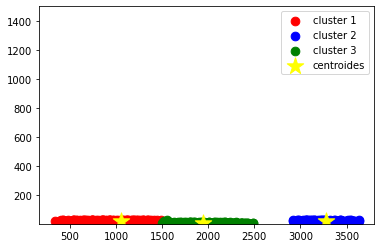

In [14]:
kmeansplot_2(clusters2, centroides2)

&emsp; É desse modo que o kmeans está enxergando os dados, e agora fica muito mais intuitivo perceber o motivo do kmeans ter clusterizado o gráfico dessa forma, como a escala do eixo x dos dados é muito maior, o kmeans enxerga muita pouca diferença entre os valores de y, o que é evidente no gráfico plotado acima.<br>
&emsp; Assim, a normalização é de extrema importancia, pois ao faze-la garantimos que o mesmo peso e importancia sejam dadas a todas as features.

#### 1.3.2 Inicialização dos centroides
&emsp;Outro aspecto que deve ser analisado é a inicialização dos centroides, dependendo da posição de início o kmeans pode acabar caindo em um mínimo local e não conseguirá prosseguir com a clusterização.<br>
&emsp; No algoritmo do kmeans que eu usei, apliquei o inicilização do tipo Forgy, ou seja, ele escolherá como centroide k pontos pertencentes ao cojunto de dados normalizado. Para verificar o impacto desse método Forgy, modificarei o kmeans para imprimir o número de iterações, e aplicarei o kmeans em um loop com 20 execuções, assim poderemos ter uma noção melhor do que está acontecendo:

In [15]:
def kmeans2(X, k):
    centroides_anterior = inicializaCentroides(X,k)
    erro = 1
    i = 0
    while erro != 0:
        clusters = defineClusters(X, centroides_anterior, k)
        centroides_novo = calculaCentroides(centroides_anterior, clusters, k)
        erro = np.linalg.norm(centroides_novo - centroides_anterior)
        centroides_anterior = cp.deepcopy(centroides_novo)
        i+= 1
    print(" - "+str(i) + " iterações")
    return clusters, centroides_novo

In [18]:
X = Dados('cluster.dat', dataset = 'training' ,norm = True)
for i in range(20):
    print("Execução " + str(i), end = ' ')
    clus, cent = kmeans2(X, 3)

Execução 0  - 4 iterações
Execução 1  - 3 iterações
Execução 2  - 2 iterações
Execução 3  - 5 iterações
Execução 4  - 16 iterações
Execução 5  - 4 iterações
Execução 6  - 3 iterações
Execução 7  - 6 iterações
Execução 8  - 4 iterações
Execução 9  - 24 iterações
Execução 10  - 4 iterações
Execução 11  - 4 iterações
Execução 12  - 5 iterações
Execução 13  - 4 iterações
Execução 14  - 4 iterações
Execução 15  - 3 iterações
Execução 16  - 3 iterações
Execução 17  - 4 iterações
Execução 18  - 4 iterações
Execução 19  - 2 iterações


&emsp; O resultado acima nos mostra como o número de iterações pode variar baseado na inicialização, note que, para esse exemplo, tivemos inicializações que levaram o kmeans a ter de 2 até 24 iterações.<br>
&emsp; O número de iterações não é o único problema que podemos ter, como dito anteriormente, dependendo da inicialização o kmeans pode cair em minimos locais. Para mostrar esse efeito vou modificar a minha função kmeans para que um dos parametros seja a inicialização do centroide e assim possamos fazer alguns testes:

In [19]:
def kmeans3(X, k, centroide_inicial):
    centroides_anterior = centroide_inicial
    erro = 1
    while erro != 0:
        clusters = defineClusters(X, centroides_anterior, k)
        centroides_novo = calculaCentroides(centroides_anterior, clusters, k)
        erro = np.linalg.norm(centroides_novo - centroides_anterior)
        centroides_anterior = cp.deepcopy(centroides_novo)
    return clusters, centroides_novo

&emsp; Do conjunto de dados normalizados achei uma inicialização que leva a um minimo local, vamos ver o resultado do kmeans:

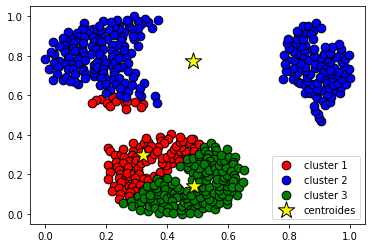

In [20]:
centroide_1 = np.array([[0.35606060, 0.3051470588], [0.378787878, 0.369485294], [0.380303030, 0.0753676]])

clus, cent = kmeans3(X,3,centroide_1)
kmeansplot(clus, cent)

<p style="text-align: justify;">
&emsp; Eu obtive essa inicialização executando o kmeans com a inicialização Forgy varias vezes até achar uma inicialização problematica, e acima podemos ver que a clusterização ficou totalmente errada, assim pode-se notar que mesmo a inicialização Forgy está suscetível a erros, o que reforça a ideia de que devemos executar o kmeans mais de uma vez para ter certeza que obtivemos uma boa clusterização.<br>
&emsp; Pode-se,também, ter problemas com a escolha de inicializações em que os pontos estão distante do conjuntos de dados, podendo levar a ter clusters vazios ou então um alto número de iterações para se obter convergencia.<br>
&emsp; É dito que a melhor inicialização que tem é a do kmeans++, pois ele garante uma maior distribuição dos centroides dentro do conjunto de dados.
</p>

### 1.4 Aplicação do conjunto de testes
<p style="text-align: justify;">
    &emsp; Agora chegou o momento de classificar os pontos do conjunto de testes, para melhor organização irei fazer novamente o treinamento (utilizando o conjunto de treinamento) com as funções ja prontas e a após isso irei utilizar os centroides que foi obtido pelo kmeans para determinar a qual cluster os pontos do conjunto de teste pertencem.
</p>

#### 1.4.1 Treinamento
&emsp; O Treinamento é simples, basta executar as funções já prontas, lembrando que,baseado em toda analise anterior, aplicaremos o k-means para k = 3:

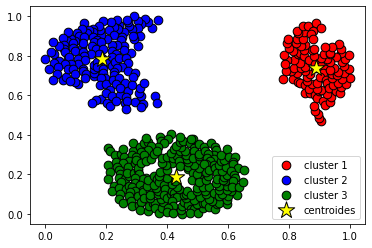

In [21]:
TrainingDataset = Dados('cluster.dat', dataset = 'training', norm = True)
clustersTreino, centroides = kmeans(X,k = 3)
kmeansplot(clustersTreino, centroides)

#### 1.4.2 Definição dos clusters do conjunto de testes
<p style="text-align: justify;">
&emsp; O Treinamento foi completo, e o que importa pra nós é a posição dos centroides, isso por que iremos definir os clusters do conjunto de testes baseado nas distancias dos centroides, em outras palavras, um ponto fará parte do cluster cujo centroide está mais próximo.<br>
&emsp; Mas primeiro preciso fazer uma função bem simples que defina o cluster baseando-se na posição dos centroides:
</p>

In [22]:
def defineCluster(centroide, testDataset):
    clusterTest = inicializaCluster(len(centroide))
    for i in range(len(testDataset)):
        for j in range(len(testDataset[i])):
            indiceMenor = 0
            distanciaAnterior = -1
            for k in range(len(centroide)):    
                distancia = np.linalg.norm(testDataset[i] - centroide[k])
                if(distanciaAnterior < 0 or distancia < distanciaAnterior):
                    indiceMenor = k
                    distanciaAnterior = distancia
            clusterTest[indiceMenor].append(testDataset[i])
    return clusterTest

In [23]:
testDataset = Dados('cluster.dat', dataset = 'test', norm = True)
clusterTestData =  defineCluster(centroides, testDataset)

Os clusters foram definidos, agora vamos plotar os centroides e os clusters obitido do conjunto de teste

In [24]:
def plotTest(clusters, centroides):
    cores = ['r','b','g','c','m','y']
    for i in range(len(clusters)):
        cluster = np.array(clusters[i])
        plt.scatter(cluster[:,0] , cluster[:,1], s=75, color=cores[i],  edgecolor='k',label='cluster '+str(i+1))
    
    
    plt.scatter(centroides[:, 0],centroides[:, 1],s=300,marker='*', c='yellow', edgecolor='k',label='centroides')

    plt.legend(scatterpoints=1)
    plt.show()

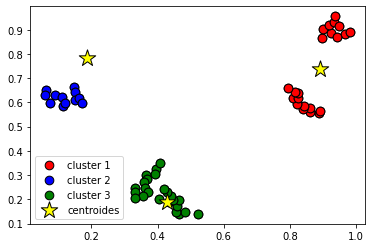

In [25]:
plotTest(clusterTestData, centroides)

<p style="text-align: justify;">
&emsp; Pode-se ver que os dados do conjunto de teste foram bem classificados e portanto o método do kmeans foi uma boa alternativa para fazer o treinamendo dos pontos do conjunto de treinamento .<br>
</p>

### 2. Agglomerative Hierarchical Clustering
&emsp;O Agglomerative Hierarchical Clustering é um método de clusterização que visa construir uma hierarquia de clusters. Neste método, inicialmente todo ponto é considerado um cluster, a medida que o algoritmo prossegue os clusters proximos sofrem merge e assim vão subindo na hierarquia.<br>
&emsp;Para fazer a clusterização basta que se execute os passos abaixo:
1. Fazer uma matriz de proximidade.
2. Fazer o merge de dois clusters próximos.
3. Atulizar a matriz de proximidade, mostrando que ja foi feito o merge desses clusters ou que um novo cluster surgiu.
4. Repetir 2 e 3 até sobre apenas 1 cluster.

&emsp;No meu caso, no o passo 4, o algoritmo irá rodar até obter um número de k clusters e todo elemento ter sido atribuido a um cluster diferente.

### 2.1 Implementação
Primeiro vou fazer todos os imports necessarios:

In [26]:
from scipy.spatial import distance_matrix
import numpy as np
import pandas as pd
import copy as cp
import matplotlib.pyplot as plt
from math import floor, ceil
%matplotlib inline

&emsp;Para fazer a leitura dos dados irei usar a mesma função que usei para o algoritmo do kmeans, lembre-se que o algoritmo faz a seguinte divisão do dataset:
<p style="text-align: center;"> | 18% treino | 2% teste | 18% treino | 2% teste | 18% treino | 2% teste | 18% treino | 2% teste | 18% treino | 2% teste |</p>

In [27]:
def Dados(caminho, dataset = 'training', norm = True):
    X = pd.read_csv(caminho, sep = '\s+', header = None)
    if(norm):
        X = (X-X.min())/(X.max()-X.min()) # Min-Max
        
    training, test = [], []
    Total = len(X)
    
    for i in range(5):
        training.append(X.head(floor(Total*0.18)))
        X = X.iloc[floor(Total*0.18):]
        test.append(X.head(ceil(Total*0.02)))
        X = X.iloc[ceil(Total*0.02):]
    
    training = pd.concat(training)
    test = pd.concat(test)
    
    if(dataset == 'training'):
        return training.values
    elif(dataset == 'test'):
        return test.values
    

&emsp; Agora farei funções auxiliares para simplificar o processo da clusterização hierarquica:
1. achaCluster: dado um ponto e o conjunto de clusters, essa função retorna a chave do cluster a qual esse ponto pertence, senão retorna -1
2. mergeClusters: dado a chave de dois clusters, essa função faz merge desses dois clusters 
3. newCluster: dado  dois pontos e o conjunto de clusters, essa função adiciona esses dois pontos a um novo clusters

In [28]:
def achaCluster(ponto,clusters):
    for key in clusters:
        for pos in range(len(clusters[key])):
            if(clusters[key][pos] == ponto):
                return key
    return -1

def mergeClusters(clus, keyA, keyB):
    clusters = cp.deepcopy(clus)
    for i in range(len(clusters[keyB])):
        clusters[keyA].append(clusters[keyB][i])
    clusters.pop(keyB)
    return clusters

def newCluster(clusters, PontoA, PontoB):
    i = len(clusters)
    keys = clusters.keys()
    while(True):
        if(i not in keys):
            clusters[i] = [PontoA,PontoB]
            break
        i += 1
    return clusters

&emsp;Agora, finalmente, vou aplicar o algoritmo do Hierarchical Clustering, note que essa função retorna o conjunto de clusters, porém o conteúdo dentro dos clusters não são os pontos e sim suas respectivas posições dos dados, assim precisei fazer uma função converte, que substitui a posição dos pontos pelos seus respectivos pontos.

In [29]:
def converte(clusters, dados):
    resultado = {}
    j = 0
    for key in clusters:
        resultado[j] = []
        for i in range(len(clusters[key])):
            resultado[j].append(dados[clusters[key][i]])
        j+= 1
    return resultado

def Hierarquico(X, k):
    dados = X.tolist()
    matrix = np.triu(distance_matrix(dados,dados))

    clusters = {}
    tamanho = 0
    while(len(clusters) > k or tamanho != len(dados)):
        Indice_min = np.where(matrix == np.min(matrix[np.nonzero(matrix)]))
        PontoA = Indice_min[0][0]
        PontoB = Indice_min[1][0]
    
        keyA = achaCluster(PontoA, clusters)
        keyB = achaCluster(PontoB, clusters)
        if(keyA == -1 and keyB == -1):
            clusters = newCluster(clusters, PontoA, PontoB)
        elif(keyA == -1):
            if(PontoA not in clusters[keyB]):
                clusters[keyB].append(PontoA)
        elif(keyB == -1):
            if(PontoB not in clusters[keyA]):
                clusters[keyA].append(PontoB)
        else:
            if(keyA != keyB):
                clusters = mergeClusters(clusters, keyA, keyB)
        
        matrix[PontoA][PontoB] = 0
        tamanho = sum(len(cluster) for cluster in clusters.values())
    clusters = converte(clusters, dados)
    return clusters

### 2.2 Execução
&emsp;Para a execução precisarei descobrir o número ideal de clusters, no kmeans usei o método elbow para isso, porém o método elbow exige os centroides para definir o número k, como o hierarchical cluster não nos da centroides irei usar a média aritimétida dos pontos do cluster no lugar do centroide.<br>

In [30]:
def elbowHierarchical(X):
    Grafico = []
    for k in range(1,9):
        Sum = 0
        media = []
        clusters = Hierarquico(X, k)
        for i in range(len(clusters)):
            media.append(np.average(clusters[i], axis=0))
        for i in range(len(clusters)):
            for j in range(len(clusters[i])):
                distancia = np.linalg.norm(clusters[i][j] - media[i])
                Sum += distancia**2
        Grafico.append([k,Sum])
    Grafico = np.array(Grafico)
    
    plt.plot(Grafico[:,0],Grafico[:,1], 'bx-')
    plt.xticks(Grafico[:,0])
    plt.xlabel('Valor de K')
    plt.ylabel('Distorção')
    plt.title('Método Elbow')
    plt.show()

Executando o código acima temos:

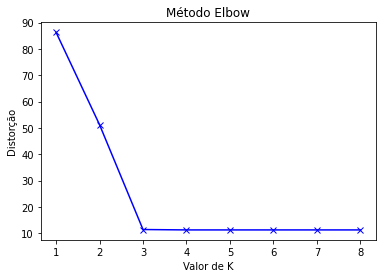

In [31]:
X = Dados('cluster.dat', dataset = 'training', norm = True)
elbowHierarchical(X)

&emsp; Pode-se perceber uma diferença marcante entre o kmeans e o hierarchical, ao executar o elbow utilziando o hierarchical clustering a resposta demorou demais para aparecer, diferentemente para o kmeans, que foi relativamente rápido.<br>
&emsp;No gráfico acima, percebe-se um cotovelo em k = 3, então para esse algoritmo irei  executar para um número de 3 clusters, mas antes vou fazer uma função para plotar o gráfico.<br>

In [32]:
def hierarchicalPlot(clusters):
    cores = ['r','b','g','c','m','y']
    for key in clusters:
        cluster = np.array(clusters[key])
        plt.scatter(cluster[:,0],cluster[:,1], s=75, color=cores[key],  edgecolor='k', label='cluster '+str(key+1))
    plt.legend(scatterpoints=1)
    plt.show()

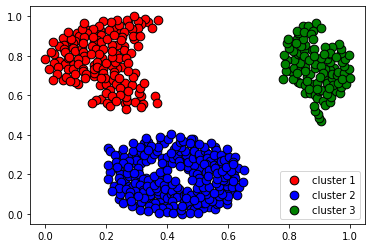

In [33]:
X = Dados('cluster.dat', dataset = 'training', norm = True)
clustersHierarchical = Hierarquico(X, 3)
hierarchicalPlot(clustersHierarchical)

&emsp;Visualmente é possivel notar que a clusterização foi ótima e os clusters estão muito bem definidos, e que o resultado da clusterização ficou identico ao do kmeans

### 2.3 Analise
&emsp;Neste tópico farei a análise do efeito da normalização.

#### 2.3.1 Normalização
&emsp; O que se espera para uma execução sem normalização, para esse método, é uma clusterização incorreta, visto que a falta de normalização da pesos diferentes as features, além disso pode-se dizer que o resultado pode ser diferente do que foi obtido no kmeans sem normalização, isso porque as métricas de separação de clusters são diferentes e, também, como os dados não estão normalizados é esperado obter um comportamento distinto. <br>
&emsp; Inicialmente irei executar o método elbow da clusterização hierarquica e ver se ira ser obtido um cotovelo bem definido:

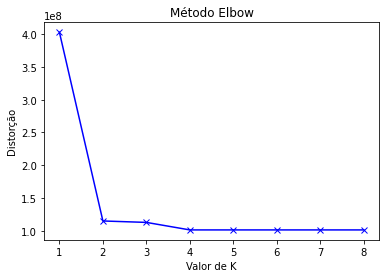

In [34]:
X2 = Dados('cluster.dat', dataset = 'training', norm = False)
elbowHierarchical(X2)

&emsp; Obtemos um cotovelo bem forte em k = 2, agora vou executar a clusterização hierarquica e fazer seu plot para observarmos a saida:

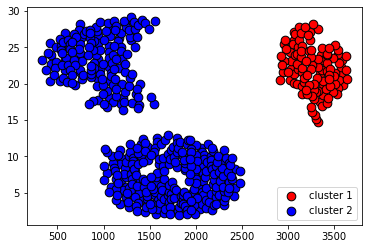

In [35]:
X2 = Dados('cluster.dat', dataset = 'training', norm = False)
clustersHierarchical2 = Hierarquico(X2, 2)
hierarchicalPlot(clustersHierarchical2)

&emsp; Pode-se dizer que para k = 2 a clusterização foi bem coerente, mas antes de executarmos para k = 3, vamos tentar entender porque o método elbow nos disse que o número ótimo de clusters é k = 2. <br>
&emsp; Vamos plotar novamente o gráfico acima, mas agora vou mexer na escala do gráfico, irei colocar o eixo y na mesma escala do eixo x, mas sem alterar a escala dos dados: 

In [36]:
def hierarchicalPlot_2(clusters):
    cores = ['r','b','g','c','m','y']
    plt. ylim(1, 1500)
    for key in clusters:
        cluster = np.array(clusters[key])
        plt.scatter(cluster[:,0],cluster[:,1], s=75, color=cores[key],  edgecolor='k', label='cluster '+str(key+1))
    plt.legend(scatterpoints=1)
    plt.show()

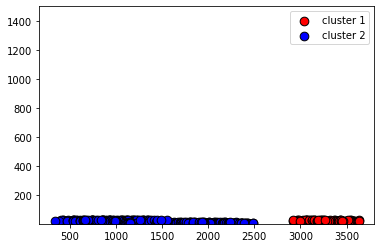

In [37]:
hierarchicalPlot_2(clustersHierarchical2)

&emsp; Olhando dessa perspectiva fica bem evidente porque o método elbow nos disse que o número ideal de clusters foi de k = 2. Agora vou executar, os dados sem normalização, para k = 3 e analisar o resultado:

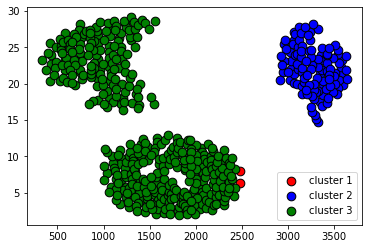

In [38]:
clustersHierarchical2 = Hierarquico(X2, 3)
hierarchicalPlot(clustersHierarchical2)

&emsp; É possível notar que para k = 3 a clusterização ficou bem esquisita, mas isso já era esperado visto que os dados não estão normalizado, mas agora vamos analisar algumas peculiaridades: <br>

1. Por que um dos clusters é extremamente pequeno e desproporcional aos outros?<br>
<p style='text-align: justify;'> A resposta para essa questão é que o número ideal de clusters, para os dados não normalizados, não é 3. No método hierarquico vamos agrupando os clusters baseando-se em distancias, quando forçamos o algoritmo parar em k = 3 impedimos que aquele pequeno cluster sofresse um merge com o cluster mais próximo, assim impedindo que obtivessemos uma melhor clusterização, isso evidencia a importancia de executar um bom método para se obter o k ideal.</p>

2. Por que a execução dos dados não normalizados, para k = 3, ficou diferente do kmeans?<br>
<p style='text-align: justify;'> Isso acontece porque as métricas de divisão dos clusters são diferentes, no kmeans os clusters são definidos baseados nas distancias dos centroides, ja no hierarquico definimos baseado na distancia entre os clusters, assim como a clusterização está sendo feita para um k incorreto e sobre dados não normalizados essas métricas tem um impacto muito grande.</p>

### 2.4 Aplicação do conjunto de testes
<p style="text-align: justify;">
    &emsp; Agora chegou o momento de classificar os pontos do conjunto de testes, para melhor organização irei fazer novamente o treinamento (utilizando o conjunto de treinamento) com as funções ja prontas e a após isso vou definir o cluster a qual os pontos do conjunto de teste pertencem baseando-se na distancia entre o ponto analisado e o ponto médio do cluster.
</p>

#### 2.4.1 Treinamento
&emsp; O Treinamento é simples, basta executar as funções já prontas, lembrando que, baseado em toda analise anterior, aplicaremos o agglomerative hierarchical clustering até que obtemos 3  clusters:

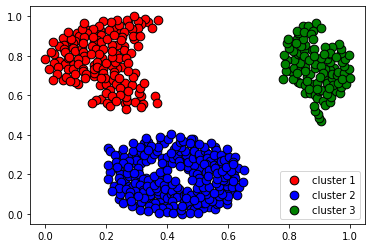

In [39]:
TrainingDataset_H = Dados('cluster.dat', dataset = 'training', norm = True)
clustersTreino_H = Hierarquico(TrainingDataset_H, 3)
hierarchicalPlot(clustersTreino_H)

#### 2.4.2 Definição dos clusters do conjunto de testes
<p style="text-align: justify;">
&emsp; O Treinamento foi completo, agora iremos definir os clusters do conjunto de testes baseado nos pontos médios dos clusters obtidos no conjunto de treinamento, em outras palavras, um ponto fará parte do cluster cuja média dos pontos dos clusters de treinamento está mais próximo.<br>
&emsp; Mas primeiro preciso fazer uma função que retorne esses pontos médiose, e uma função simples que defina o cluster baseando-se na posição dos pontos médios:
</p>

In [40]:
def pontosMedios(clustersTreino):
    pontoMedio = []
    for i in range(len(clustersTreino)):
        pontoMedio.append(np.average(clustersTreino[i], axis=0))
    return pontoMedio

def defineCluster_H(pontosMedios, testDataset):
    clusterTest = inicializaCluster(len(pontosMedios))
    for i in range(len(testDataset)):
        for j in range(len(testDataset[i])):
            indiceMenor = 0
            distanciaAnterior = -1
            for k in range(len(pontosMedios)):    
                distancia = np.linalg.norm(testDataset[i] - pontosMedios[k])
                if(distanciaAnterior < 0 or distancia < distanciaAnterior):
                    indiceMenor = k
                    distanciaAnterior = distancia
            clusterTest[indiceMenor].append(testDataset[i])
    return clusterTest

In [41]:
pontosMedio = pontosMedios(clustersTreino_H)
testDataset_H = Dados('cluster.dat', dataset = 'test', norm = True)
clusterTestData_H =  defineCluster_H(pontosMedio, testDataset_H)

Os clusters foram definidos, agora vamos plotar os clusters obitido do conjunto de teste

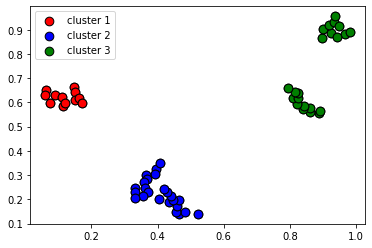

In [42]:
def plotTest_H(clusters):
    cores = ['r','b','g','c','m','y']
    for i in range(len(clusters)):
        cluster = np.array(clusters[i])
        plt.scatter(cluster[:,0] , cluster[:,1], s=75, color=cores[i],  edgecolor='k',label='cluster '+str(i+1))
    
    plt.legend(scatterpoints=1)
    plt.show()

plotTest_H(clusterTestData_H)

<p style="text-align: justify;">
&emsp; Pode-se ver que os dados do conjunto de teste foram bem classificados e portanto o método do agglomerative hierarchical clustering foi uma boa alternativa para fazer o treinamendo dos pontos do conjunto de treinamento .<br>
</p>

### 3. Um novo conjunto de dados:

<p style="text-align: justify;">
&emsp; Agora irei usar um novo dataset, o Hungary Chickenpox Dataset, este conjunto de dados contém informações sobre o número de casos semanais de catapóra em 20 condados da Hungria.<br>
&emsp; Existem 21 features em cada caso do conjunto de dados: A primeira coluna contém a data da coleta de dados, e as demais colunas são referentes a quantidade de casos em cada condado, além disso esse dataset possui 522 linhas, vou fazer um print abaixo para deixar explicito:<br>
</p>

In [137]:
HungaryDataset = pd.read_csv('hungary_chickenpox.csv', sep = ',')
HungaryDataset

,Date,BUDAPEST,BARANYA,BACS,BEKES,BORSOD,CSONGRAD,FEJER,GYOR,HAJDU,...,JASZ,KOMAROM,NOGRAD,PEST,SOMOGY,SZABOLCS,TOLNA,VAS,VESZPREM,ZALA
0,03/01/2005,168,79,30,173,169,42,136,120,162,...,130,57,2,178,66,64,11,29,87,68
1,10/01/2005,157,60,30,92,200,53,51,70,84,...,80,50,29,141,48,29,58,53,68,26
2,17/01/2005,96,44,31,86,93,30,93,84,191,...,64,46,4,157,33,33,24,18,62,44
3,24/01/2005,163,49,43,126,46,39,52,114,107,...,63,54,14,107,66,50,25,21,43,31
4,31/01/2005,122,78,53,87,103,34,95,131,172,...,61,49,11,124,63,56,7,47,85,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517,01/12/2014,95,12,41,6,39,0,16,15,14,...,56,7,13,122,4,23,4,11,110,10
518,08/12/2014,43,39,31,10,34,3,2,30,25,...,34,20,18,70,36,5,23,22,63,9
519,15/12/2014,35,7,15,0,0,0,7,7,4,...,30,36,4,72,5,21,14,0,17,10
520,22/12/2014,30,23,8,0,11,4,1,9,10,...,27,17,21,12,5,17,1,1,83,2


&emsp;Para fazer a clusterização irei remover a coluna Date, além disso,note que agora estou usando uma csv (vírgula como separador) e com um cabeçalho, então vou precisar modificar, um pouco, a função dados:

In [33]:
import pandas as pd
from math import floor, ceil

def Dados_2(caminho, dataset = 'training', norm = True):
    X = pd.read_csv(caminho, sep = ',')
    del X['Date']
     
    if(norm):
        X = (X-X.min())/(X.max()-X.min()) # Min-Max
        
    training, test = [], []
    Total = len(X)
    
    for i in range(5):
        training.append(X.head(floor(Total*0.18)))
        X = X.iloc[floor(Total*0.18):]
        test.append(X.head(ceil(Total*0.02)))
        X = X.iloc[ceil(Total*0.02):]
    
    training = pd.concat(training)
    test = pd.concat(test)
    if(dataset == 'training'):
        return training.values
    elif(dataset == 'test'):
        return test.values

&emsp; Agora vamos fazer a leitura dos dados:

In [34]:
hungaryTrainingSet = Dados_2('hungary_chickenpox.csv', dataset = 'training', norm = True)

#### 3.1 Kmeans:

&emsp; Para executar o k-means, precisamos achar um bom número k de clusters, para isso vou executar o método do cotovelo. <br>

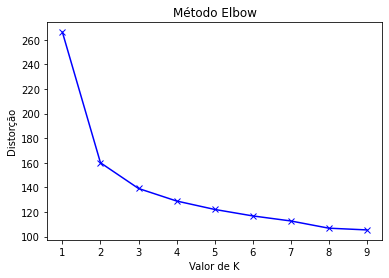

In [35]:
elbow(hungaryTrainingSet)

&emsp; Parece que temos um cotovelo em k = 2, irei fazer a clusterização para esse valor de k:

In [36]:
clusters_hungary, centroides_hungary = kmeans(hungaryTrainingSet, k = 2)

&emsp; Ótimo, mas e agora? Não temos como fazer o plot dos clusters visto que estamos trabalhando com 20 dimensões, mas mesmo assim vou plotar um gráfico 2d com as duas primeiras features pra ver o que irei obter:

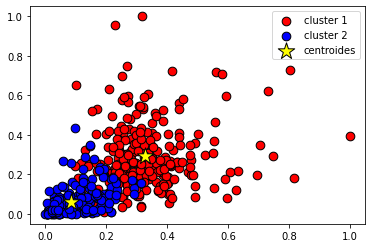

In [39]:
kmeansplot(clusters_hungary, centroides_hungary)

<p style="text-align: justify;">
&emsp; Mesmo sendo possivel ver dois clusters, esse resultado não nos diz praticamente nada, afinal nele estão faltando serem consideradas 18 dimensões, portanto o que irei fazer agora é fazer a classificação do conjunto de testes e definir o coeficiente de silhouette para avaliar o resultado final. 
</p>

In [139]:
hungaryTestSet = Dados_2('hungary_chickenpox.csv', dataset = 'test', norm = True)
hungaryClusterTest =  defineCluster(centroides_hungary, hungaryTestSet)

<p style="text-align: justify;">
&emsp; Lembre-se que a função defineCluster() classica os pontos do conjunto de teste baseados nos centroides que foram definidos usando o conjunto de treinamento. <br>
&emsp; Agora irei implementar e executar o coeficiente de silhouette em relação aos clusters do conjunto de testes obtidos na função defineCluster() e os centroides obtidos no k-means.
</p>

In [149]:
def coeficienteA(clusters):
    a = []
    for i in range(len(clusters)):
        for j in range(len(clusters[i])):
            Sum = 0
            for k in range(len(clusters[i])):
                if(k!=j):
                    Sum += np.linalg.norm(clusters[i][j] - clusters[i][k])
            a.append(Sum/(len(clusters[i])))
    return a

def coeficienteB(clusters,centroides):
    b = []
    for i in range(len(clusters)):
        for j in range(len(clusters[i])):
            Sum = 0
            atual = -1
            indice = 0
            for q in range(len(centroides)):
                if(q != i and (atual < 0 or atual < np.linalg.norm(clusters[i][j] - centroides[q]))):
                    indice = q
            for k in range(len(clusters[indice])):
                Sum += np.linalg.norm(clusters[i][j] - clusters[indice][k])
            b.append(Sum/(len(clusters[indice]) - 1))
    return b

def coeficenteSilhouette(clusters,centroides):
    a = coeficienteA(clusters)
    b = coeficienteB(clusters,centroides)
    coef = []
    
    for i in range(len(a)):
        s = (b[i]-a[i])/max(a[i],b[i])
        coef.append(s)
        
    retorno = []
    aux = 0
    for i in range(len(clusters)):
        retorno.append([])
        for j in range(len(clusters[i])):
            retorno[i].append(coef[aux])
            aux += 1
            
    media = np.average(coef)
    
    return media

In [153]:
Coef = coeficenteSilhouette(hungaryClusterTest, centroides_hungary)
print("Coeficiente de Silhouette = " + str(Coef.round(5)))

Coeficiente de Silhouette = 0.33288


&emsp; Acima é possivel ver que o coeficiente de silhouette é mediano, o que nos leva a crer que a classificação do conjunto de testes nos centroides do k-means foi razoavel, porém devemos lembrar que um baixo coeficiente de silhouette não quer dizer que a clusterização foi ruim.

#### 3.2 Hierarchical Clustering:

<p style="text-align: justify;">
&emsp; Antes de analisar os dados vamos relembrar como implementei o hierarchical clustering, originalmente esse algoritmo vai fazendo merge dos clusters próximos até sobrar apenas um único cluster, após isso é analisado as distancias no dendrograma e é decidido qual o número ideal de clusters.<br>
&emsp; Essencialmente eu fiz o mesmo algoritmo, só alterei a parte de decisão do número de clusters, no meu código deve-se passar um número k de clusters como parametro, assim o código irá parar quando o número de clusters for menor ou igual a k e todo elemento do conjunto de dados já ter sido analisado. <br>
&emsp; E porque estou relembrando toda essa história? Bom, quando fui executar o meu código para k = 2, obtive como resultado apenas 1 cluster, isso acontece porque obtemos 1 cluster antes do código analisar todo conjunto de dados e nenhum ponto novo a ser analisado está longe o bastante para se criar um novo cluster. Mas esse problema não ocorre apenas para k = 2, ocorre também para varios valores de k, veja abaixo:<br>
</p>

In [182]:
for k in range(2,10):
    clusters_hungary_H = Hierarquico(hungaryTrainingSet, k = 6)
    print("Para k = " + str(k) + " Número de clusters = " + str(len(clusters_hungary_H)))

Para k = 2 Número de clusters = 1
Para k = 3 Número de clusters = 1
Para k = 4 Número de clusters = 1
Para k = 5 Número de clusters = 1
Para k = 6 Número de clusters = 1
Para k = 7 Número de clusters = 1
Para k = 8 Número de clusters = 1
Para k = 9 Número de clusters = 1


<p style="text-align: justify;">
&emsp; Ou seja, não está sendo possivel forçar o número de clusters usando o meu algoritmo, o que indica que para o aglomerative hierarchical clustering com single linkage a melhor clusterização para esse conjunto de dados seja com 1 cluster que englobe todos os ponto.<br>
&emsp; Isso significa que o algoritmo está errado? Não, o método só não é bom para esse conjunto de dados, provavelmente se usarmos algum outro tipo de linkage obteriamos uma melhor resultado.<br>
</p>

### 4. Comparação dos métodos:


<p style="text-align: justify;">
&emsp; No primeiro conjunto de dados, os dois algoritmos obtiveram praticamente a mesma clusterização, já no segundo conjunto de dados a clusterização usando o hierarchical clustering nos deu apenas 1 clusters, o que demonstra que o kmeans foi melhor para esse conjunto, mas isso não nos diz que o hierarchical clustering é ruim, apenas mostra que provavelmente o single linkage não é adequado para esses dados, provavelmente utilizando outro linkage obteriamos um resultado ainda melhor que o kmeans.<br>
&emsp; Outra diferença muito marcante é a velocidade de execução, o hierarchical clustering se mostrou extremamente mais lento para executar do que o kmeans, isso em ambos conjuntos de dados, isso está diretamente associado a complexidade dos algoritmos.<br>
&emsp; Uma vantagem do hierarchical clustering é que não se precisa fazer inicialização de centroides, como visto no kmeans, o valor inicial dos centroides pode influenciar bastante na clusterização, as vezes podemos ter inicializações que levam a minimos locais, fazendo com que a clusterização fique incorreta, ou inicializações que aumentam bastante o número de iterações do algoritmo, nos mostrando assim que a inicialização é uma parte bem sensivel do algoritmo e que precisa de cuidado ao ser feita.<br>
&emsp; *Obs: Outra vantagem do hierarchical clustering é que nele não se precisa passar o número de clusters, porém como dito no tópico anterior eu não implementei desse modo.<br> <br>
    
&emsp; Ou seja, os métodos tem suas vantagens e desvantagens, é muito provavel que o melhor método a ser usado depende da situação, isso é, o conjunto de dados, o tipo de clusterização que está buscando, o número de clusters buscado, entre outros. <br>

# Parte 2:
